# IMPORTS

In [17]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, SimpleRNN, Dropout, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)


# DATASET PATH

In [18]:
DATASET_PATH = r'C:\Users\amity\Downloads\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset'
IMG_SIZE = 128
categories = ['Normal cases', 'Bengin cases', 'Malignant cases']

# AUGMENTATION

In [19]:
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


## LOADING DATASET

In [20]:
def load_data(dataset_path):
    images, labels = [], []
    print("Loading images...")

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in tqdm(os.listdir(category_path), desc=f"Loading {category}"):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(categories.index(category))
                
                if category == 'Bengin cases':
                    img_expanded = img.reshape((1, IMG_SIZE, IMG_SIZE, 1))
                    for _ in range(2):
                        aug_iter = augmentor.flow(img_expanded, batch_size=1)
                        aug_img = next(aug_iter)[0].astype(np.uint8).squeeze()
                        images.append(aug_img)
                        labels.append(categories.index(category))

    images = np.array(images) / 255.0
    labels = np.array(labels)
    return images[..., np.newaxis], labels

images, labels = load_data(DATASET_PATH)

Loading images...


Loading Malignant cases: 100%|██████████| 561/561 [00:01<00:00, 289.11it/s]


## SPLIT DATA

In [21]:
train_val_images = images
train_val_labels = labels
train_val_labels_cat = to_categorical(train_val_labels, num_classes=len(categories))

x_train, x_val, y_train, y_val = train_test_split(
    train_val_images, train_val_labels_cat,
    test_size=0.2, stratify=train_val_labels, random_state=42
)

train_val_labels_flat = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_val_labels_flat),
    y=train_val_labels_flat
)
class_weight_dict = dict(enumerate(class_weights))

print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")
print("Class weights:", class_weight_dict)

Training samples: 1069, Validation samples: 268
Class weights: {0: 1.07007007007007, 1: 1.2372685185185186, 2: 0.7953869047619048}


## CNN MODEL

In [22]:
def build_cnn():
    model = Sequential([ 
        Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn()
cnn_history = cnn_model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/10
34/34 [==============================] - 13s 343ms/step - loss: 1.3854 - accuracy: 0.4846 - val_loss: 0.8377 - val_accuracy: 0.6418
Epoch 2/10
34/34 [==============================] - 12s 349ms/step - loss: 0.6161 - accuracy: 0.7521 - val_loss: 0.5620 - val_accuracy: 0.7500
Epoch 3/10
34/34 [==============================] - 16s 478ms/step - loss: 0.2845 - accuracy: 0.9214 - val_loss: 0.2189 - val_accuracy: 0.9291
Epoch 4/10
34/34 [==============================] - 17s 505ms/step - loss: 0.1298 - accuracy: 0.9570 - val_loss: 0.1807 - val_accuracy: 0.9440
Epoch 5/10
34/34 [==============================] - 17s 499ms/step - loss: 0.0598 - accuracy: 0.9888 - val_loss: 0.1328 - val_accuracy: 0.9627
Epoch 6/10
34/34 [==============================] - 15s 431ms/step - loss: 0.0196 - accuracy: 0.9981 - val_loss: 0.0837 - val_accuracy: 0.9664
Epoch 7/10
34/34 [==============================] - 15s 446ms/step - loss: 0.0270 - accuracy: 0.9953 - val_loss: 0.0763 - val_accuracy: 0.9776

## RNN MODEL

In [23]:
def build_rnn():
    model = Sequential([
        Reshape((IMG_SIZE, IMG_SIZE), input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        SimpleRNN(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn()
rnn_history = rnn_model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/10
34/34 [==============================] - 3s 50ms/step - loss: 1.0047 - accuracy: 0.5257 - val_loss: 0.8499 - val_accuracy: 0.6493
Epoch 2/10
34/34 [==============================] - 1s 33ms/step - loss: 0.7111 - accuracy: 0.7399 - val_loss: 0.5313 - val_accuracy: 0.8246
Epoch 3/10
34/34 [==============================] - 1s 38ms/step - loss: 0.4257 - accuracy: 0.8578 - val_loss: 0.3918 - val_accuracy: 0.8507
Epoch 4/10
34/34 [==============================] - 1s 32ms/step - loss: 0.3269 - accuracy: 0.8896 - val_loss: 0.3065 - val_accuracy: 0.8843
Epoch 5/10
34/34 [==============================] - 1s 38ms/step - loss: 0.2033 - accuracy: 0.9373 - val_loss: 0.2370 - val_accuracy: 0.9142
Epoch 6/10
34/34 [==============================] - 1s 34ms/step - loss: 0.1471 - accuracy: 0.9495 - val_loss: 0.2681 - val_accuracy: 0.8918
Epoch 7/10
34/34 [==============================] - 1s 38ms/step - loss: 0.1063 - accuracy: 0.9710 - val_loss: 0.2773 - val_accuracy: 0.9142
Epoch 8/10
34

## ANN MODEL

In [24]:
def build_ann():
    model = Sequential([
        Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ann_model = build_ann()
ann_history = ann_model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    class_weight=class_weight_dict
)

Epoch 1/10
34/34 [==============================] - 3s 56ms/step - loss: 3.3752 - accuracy: 0.3611 - val_loss: 1.1178 - val_accuracy: 0.4813
Epoch 2/10
34/34 [==============================] - 2s 56ms/step - loss: 1.1129 - accuracy: 0.4565 - val_loss: 0.9973 - val_accuracy: 0.5149
Epoch 3/10
34/34 [==============================] - 2s 59ms/step - loss: 0.9702 - accuracy: 0.4967 - val_loss: 0.8058 - val_accuracy: 0.6716
Epoch 4/10
34/34 [==============================] - 2s 53ms/step - loss: 0.9331 - accuracy: 0.4958 - val_loss: 0.8797 - val_accuracy: 0.6194
Epoch 5/10
34/34 [==============================] - 2s 53ms/step - loss: 0.9432 - accuracy: 0.4958 - val_loss: 0.8265 - val_accuracy: 0.6604
Epoch 6/10
34/34 [==============================] - 2s 46ms/step - loss: 0.8753 - accuracy: 0.5351 - val_loss: 0.7735 - val_accuracy: 0.6530
Epoch 7/10
34/34 [==============================] - 2s 65ms/step - loss: 0.8710 - accuracy: 0.5575 - val_loss: 0.7517 - val_accuracy: 0.6866
Epoch 8/10
34

## MODEL EVALUATION

In [25]:
def evaluate_model(model, x_data, y_data, name):
    y_pred = model.predict(x_data)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_data, axis=1)
    print(f"\n{name} Model Evaluation:")
    print(confusion_matrix(y_true_classes, y_pred_classes))
    print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

evaluate_model(cnn_model, x_val, y_val, "CNN")
evaluate_model(rnn_model, x_val, y_val, "RNN")
evaluate_model(ann_model, x_val, y_val, "ANN")

9/9 [==============================] - 1s 64ms/step

CNN Model Evaluation:
[[ 83   0   0]
 [  3  67   2]
 [  0   1 112]]
                 precision    recall  f1-score   support

   Normal cases       0.97      1.00      0.98        83
   Bengin cases       0.99      0.93      0.96        72
Malignant cases       0.98      0.99      0.99       113

       accuracy                           0.98       268
      macro avg       0.98      0.97      0.98       268
   weighted avg       0.98      0.98      0.98       268

9/9 [==============================] - 0s 16ms/step

RNN Model Evaluation:
[[ 83   0   0]
 [  2  64   6]
 [  0   2 111]]
                 precision    recall  f1-score   support

   Normal cases       0.98      1.00      0.99        83
   Bengin cases       0.97      0.89      0.93        72
Malignant cases       0.95      0.98      0.97       113

       accuracy                           0.96       268
      macro avg       0.96      0.96      0.96       268
   weighted 

## PERFORMANCE PLOTS

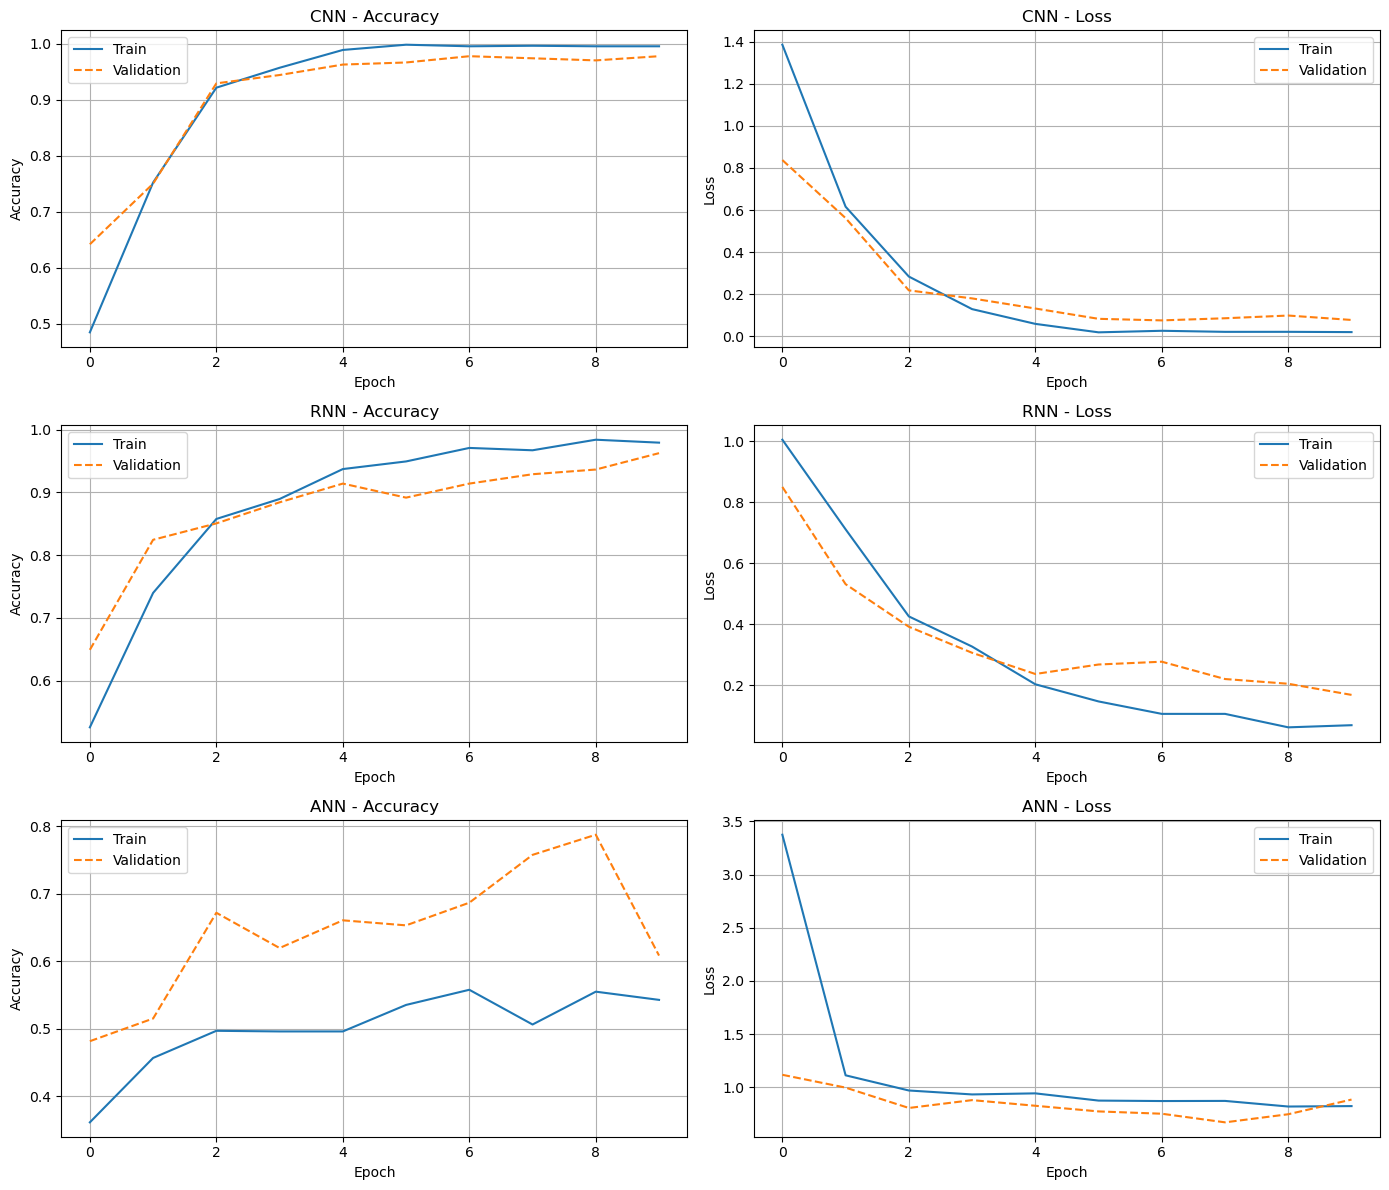

In [26]:
def plot_performance_grid(histories, labels):
    fig, axs = plt.subplots(len(histories), 2, figsize=(14, 12))
    
    for i, (history, label) in enumerate(zip(histories, labels)):
        # Accuracy subplot
        axs[i][0].plot(history.history['accuracy'], label='Train')
        axs[i][0].plot(history.history['val_accuracy'], linestyle='--', label='Validation')
        axs[i][0].set_title(f'{label} - Accuracy')
        axs[i][0].set_xlabel('Epoch')
        axs[i][0].set_ylabel('Accuracy')
        axs[i][0].legend()
        axs[i][0].grid(True)

        # Loss subplot
        axs[i][1].plot(history.history['loss'], label='Train')
        axs[i][1].plot(history.history['val_loss'], linestyle='--', label='Validation')
        axs[i][1].set_title(f'{label} - Loss')
        axs[i][1].set_xlabel('Epoch')
        axs[i][1].set_ylabel('Loss')
        axs[i][1].legend()
        axs[i][1].grid(True)

    plt.tight_layout()
    plt.show()

plot_performance_grid([cnn_history, rnn_history, ann_history], ['CNN', 'RNN', 'ANN'])


## EXPLAINABILITY (Grad-CAM, LIME & SHAP)

In [27]:
def compare_all_models_explainability(models, model_names, image, x_train_sample):

    fig, axs = plt.subplots(len(models), 3, figsize=(15, 5 * len(models)))
    axs = np.array(axs).reshape(len(models), 3)

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        # ========== Grad-CAM ==========
        try:
            last_conv_layer = next((layer.name for layer in reversed(model.layers) if isinstance(layer, Conv2D)), None)
            if last_conv_layer:
                grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
                with tf.GradientTape() as tape:
                    conv_outputs, predictions = grad_model(image)
                    loss = predictions[:, np.argmax(predictions[0])]
                grads = tape.gradient(loss, conv_outputs)[0]
                weights = tf.reduce_mean(grads, axis=(0, 1))
                cam = np.zeros(conv_outputs[0].shape[:2], dtype=np.float32)
                for j, w in enumerate(weights):
                    cam += w * conv_outputs[0][:, :, j]
                cam = np.maximum(cam, 0)
                cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
                cam = cam - cam.min()
                cam = cam / cam.max()
                axs[i][0].imshow(image[0].squeeze(), cmap='gray')
                axs[i][0].imshow(cam, cmap='jet', alpha=0.5)
                axs[i][0].set_title(f"{model_name} - Grad-CAM")
            else:
                axs[i][0].text(0.5, 0.5, "No Conv2D layer", ha='center', va='center')
        except Exception as e:
            axs[i][0].text(0.5, 0.5, f"Grad-CAM error:\n{str(e)}", ha='center', va='center')

        # ========== LIME ==========
        try:
            explainer = lime_image.LimeImageExplainer()

            def predict_fn(images):
                images = np.mean(images, axis=-1, keepdims=True)
                return model.predict(images)

            explanation = explainer.explain_instance(
                image[0].squeeze().astype('double'),
                classifier_fn=predict_fn,
                top_labels=1,
                hide_color=0,
                num_samples=1000
            )
            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=True,
                num_features=5,
                hide_rest=False
            )
            axs[i][1].imshow(mark_boundaries(temp / 255.0, mask))
            axs[i][1].set_title(f"{model_name} - LIME")
        except Exception as e:
            axs[i][1].text(0.5, 0.5, f"LIME error:\n{str(e)}", ha='center', va='center')

        # ========== SHAP ==========
        try:
            unsupported_layers = (tf.keras.layers.LSTM, tf.keras.layers.GRU, tf.keras.layers.SimpleRNN)
            if any(isinstance(layer, unsupported_layers) for layer in model.layers):
                raise NotImplementedError("SHAP not supported for RNN-based models")

            background = x_train_sample[:100]
            explainer = shap.DeepExplainer(model, background)
            shap_values = explainer.shap_values(image)

            # Convert grayscale image to RGB for SHAP visualization
            test_img = image[0]
            if test_img.shape[-1] == 1:
                test_img_rgb = np.repeat(test_img, 3, axis=-1)
            else:
                test_img_rgb = test_img

            shap_values_rgb = [np.repeat(sv[0], 3, axis=-1) if sv[0].shape[-1] == 1 else sv[0] for sv in shap_values]

            axs[i][2].imshow(test_img_rgb)
            axs[i][2].set_title(f"{model_name} - SHAP Overlay")
            axs[i][2].axis('off')
            # Optional: overlay heatmap manually using `imshow` or plot below
            # shap.image_plot(shap_values_rgb, [test_img_rgb], show=False)
        except NotImplementedError:
            axs[i][2].text(0.5, 0.5, "SHAP not supported\nfor this model type", ha='center', va='center')
        except Exception as e:
            axs[i][2].text(0.5, 0.5, f"SHAP error:\n{str(e)}", ha='center', va='center')

    for ax_row in axs:
        for ax in ax_row:
            ax.axis('off')

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


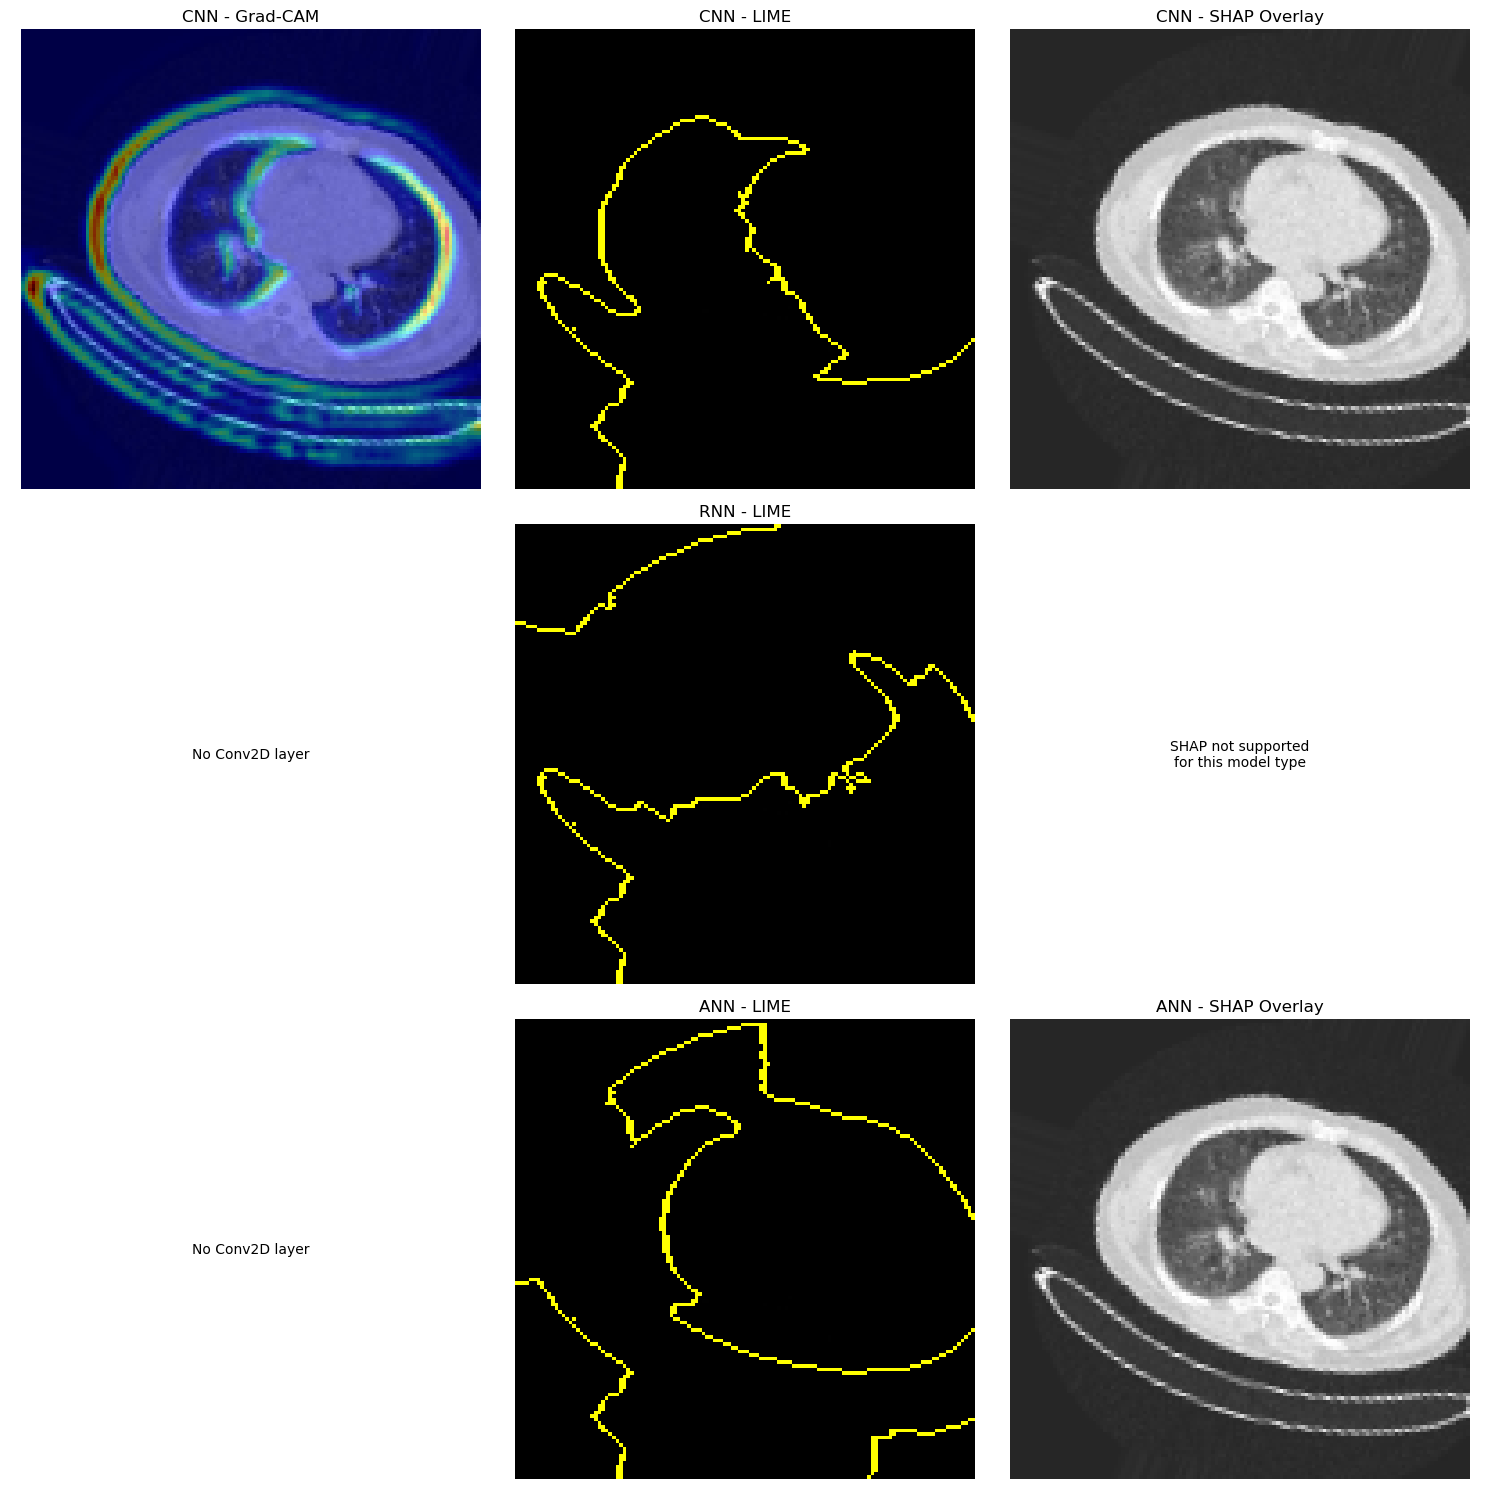

In [28]:
compare_all_models_explainability(
    models=[cnn_model, rnn_model, ann_model],
    model_names=["CNN", "RNN", "ANN"],
    image=x_val[0:1],
    x_train_sample=x_train
)
